# Brain MRI segmentation using deep learning (VNet and basic UNet)

Authors:

> Esteban Vaca

> Jhon M. Gomez

> Sergio Tascon

In order to run this notebook properly, you need to first add the datasets to your google drive

Raw dataset: [here](https://drive.google.com/file/d/1HAR1m_9YedaVra71g6D5qyBEgigfoBzj/view?usp=sharing)

Normalized dataset: [here](https://drive.google.com/file/d/1_rw7Z43F0kTI3PiEJjb3u0bFlXkusHD9/view?usp=sharing)

A modified version of the script for patch creation is also required. Please add it to your drive as well:

[script](https://drive.google.com/file/d/1P4jHleQLf9FnIAXodEPI6vXdZNAhMaXg/view?usp=sharing)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


##Installation of ants and donwload of scripts provided by Sergi Valverde

In [0]:
!pip install https://github.com/ANTsX/ANTsPy/releases/download/v0.1.8/antspy-0.1.7-cp36-cp36m-linux_x86_64.whl
!pip install statsmodels
import os
import random
import torch
import ants
import numpy as np

# upload files (weird)
!git clone https://github.com/sergivalverde/MAIA_seminar.git

%load_ext autoreload
%autoreload 2

     |████████████████████████████████| 255.7MB 56kB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
Using TensorFlow backend.


Cloning into 'MAIA_seminar'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 67 (delta 23), reused 56 (delta 13), pack-reused 0
Unpacking objects: 100% (67/67), done.


## Import dataset

Depending on the dataset that you would like to test, please uncomment or comment the corresponding line

In [0]:
!cp /content/gdrive/My\ Drive/Data.zip /content/data.zip
#!cp /content/gdrive/My\ Drive/Data_norm_matching.zip /content/data.zip

Download utls files for patch creation

In [0]:
!cp /content/gdrive/My\ Drive/utls.py /content/utls.py

Decompress data

In [0]:
!unzip data.zip

Archive:  data.zip
   creating: Data/
   creating: Data/Test_Set/
   creating: Data/Test_Set/IBSR_02/
  inflating: Data/Test_Set/IBSR_02/IBSR_02.nii.gz  
   creating: Data/Test_Set/IBSR_10/
  inflating: Data/Test_Set/IBSR_10/IBSR_10.nii.gz  
   creating: Data/Test_Set/IBSR_15/
  inflating: Data/Test_Set/IBSR_15/IBSR_15.nii.gz  
   creating: Data/Training_Set/
   creating: Data/Training_Set/IBSR_01/
  inflating: Data/Training_Set/IBSR_01/.DS_Store  
  inflating: Data/Training_Set/IBSR_01/IBSR_01.nii.gz  
  inflating: Data/Training_Set/IBSR_01/IBSR_01_seg.nii.gz  
   creating: Data/Training_Set/IBSR_03/
  inflating: Data/Training_Set/IBSR_03/IBSR_03.nii.gz  
  inflating: Data/Training_Set/IBSR_03/IBSR_03_seg.nii.gz  
   creating: Data/Training_Set/IBSR_04/
  inflating: Data/Training_Set/IBSR_04/IBSR_04.nii.gz  
  inflating: Data/Training_Set/IBSR_04/IBSR_04_seg.nii.gz  
   creating: Data/Training_Set/IBSR_05/
  inflating: Data/Training_Set/IBSR_05/IBSR_05.nii.gz  
  inflating: Data/Train

Remove .zip file

In [0]:
!rm data.zip

## Function for creation of the lists of files for the training

In [0]:
def create_training_validation_sets_specific(options: dict, validation_samples, norm=False):
    """
    Generate the input dictionaries for training and validation
    Parameters
    ----------
    options : Define the paths for the training and validation sets to be used
    must contain the following:
                options['training_path']
                options['test_path']
                options['val_split']

    Returns
    -------
    input_dictionary : Contains all the paths of files to feed the network.
                input_dictionary['input_train_data']
                input_dictionary['input_train_labels']....

    """

    if(norm):
      ending = '_norm'
    else:
      ending = ''

    training_scans = os.listdir(options['training_path'])
    validation_scans = validation_samples
    #Remove elements from training_scans
    for elem in validation_samples:
      training_scans.remove(elem)

    test_scans = os.listdir(options['test_path']) #Test remains whole validation folder

    input_dictionary = {}

    input_dictionary['input_train_data'] = {scan: [os.path.join(options['training_path'], scan,
                                                                scan + ending + '.nii.gz')] for scan in training_scans}

    input_dictionary['input_train_labels'] = {scan: [os.path.join(options['training_path'], scan,
                                                                  scan + '_seg.nii.gz')] for scan in training_scans}

    input_dictionary['input_train_rois'] = {scan: [os.path.join(options['training_path'], scan,
                                                                scan + '_ROI.nii.gz')] for scan in training_scans}

    input_dictionary['input_val_data'] = {scan: [os.path.join(options['training_path'], scan,
                                                              scan + ending+'.nii.gz')] for scan in validation_scans}

    input_dictionary['input_val_labels'] = {scan: [os.path.join(options['training_path'], scan,
                                                                scan + '_seg.nii.gz')] for scan in validation_scans}

    input_dictionary['input_val_rois'] = {scan: [os.path.join(options['training_path'], scan,
                                                              scan + '_ROI.nii.gz')] for scan in validation_scans}


    input_dictionary['input_test_data'] = {scan: [os.path.join(options['test_path'], scan,
                                                               scan + ending + '.nii.gz')] for scan in test_scans}

    input_dictionary['input_test_labels'] = {scan: [os.path.join(options['test_path'], scan,
                                                                 scan + '_seg.nii.gz')] for scan in test_scans}

    input_dictionary['input_test_rois'] = {scan: [os.path.join(options['test_path'], scan,
                                                               scan + '_ROI.nii.gz')] for scan in test_scans}

    return input_dictionary

## Architectures

####VNet with batch normalization

In [0]:
import torch.nn as nn
import torch.nn.functional as F

def passthrough(x, **kwargs):
    return x

def ELUCons(elu, nchan):
    if elu:
        return nn.ELU(inplace=True)
    else:
        return nn.PReLU(nchan)

# normalization between sub-volumes is necessary
# for good performance
class ContBatchNorm3d(nn.modules.batchnorm._BatchNorm):
    def _check_input_dim(self, input):
        if input.dim() != 5:
            raise ValueError('expected 5D input (got {}D input)'
                             .format(input.dim()))
        super(ContBatchNorm3d, self)._check_input_dim(input)

    def forward(self, input):
        self._check_input_dim(input)
        return F.batch_norm(
            input, self.running_mean, self.running_var, self.weight, self.bias,
            True, self.momentum, self.eps)


class LUConv(nn.Module):
    def __init__(self, nchan, elu):
        super(LUConv, self).__init__()
        self.relu1 = ELUCons(elu, nchan)
        self.conv1 = nn.Conv3d(nchan, nchan, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm3d(nchan)

    def forward(self, x):
        out = self.relu1(self.bn1(self.conv1(x)))
        return out


def _make_nConv(nchan, depth, elu):
    layers = []
    for _ in range(depth):
        layers.append(LUConv(nchan, elu))
    return nn.Sequential(*layers)



class InputTransition(nn.Module):
    def __init__(self, outChans, elu):
        super(InputTransition, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm3d(16)
        self.relu1 = ELUCons(elu, 16)

    def forward(self, x):
        #print(x.shape)
        # do we want a PRELU here as well?
        out = self.bn1(self.conv1(x))
        # split input in to 16 channels
        x16 = torch.cat((x, x, x, x, x, x, x, x,
                         x, x, x, x, x, x, x, x), 1)
        #print(out.shape)
        #print(x16.shape)
        out = self.relu1(torch.add(out, x16))
        return out


class DownTransition(nn.Module):
    def __init__(self, inChans, nConvs, elu, dropout=False):
        super(DownTransition, self).__init__()
        outChans = 2*inChans
        self.down_conv = nn.Conv3d(inChans, outChans, kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm3d(outChans)
        self.do1 = passthrough
        self.relu1 = ELUCons(elu, outChans)
        self.relu2 = ELUCons(elu, outChans)
        if dropout:
            self.do1 = nn.Dropout3d()
        self.ops = _make_nConv(outChans, nConvs, elu)

    def forward(self, x):
        down = self.relu1(self.bn1(self.down_conv(x)))
        out = self.do1(down)
        out = self.ops(out)
        out = self.relu2(torch.add(out, down))
        return out


class UpTransition(nn.Module):
    def __init__(self, inChans, outChans, nConvs, elu, dropout=False):
        super(UpTransition, self).__init__()
        self.up_conv = nn.ConvTranspose3d(inChans, outChans // 2, kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm3d(outChans // 2)
        self.do1 = passthrough
        self.do2 = nn.Dropout3d()
        self.relu1 = ELUCons(elu, outChans // 2)
        self.relu2 = ELUCons(elu, outChans)
        if dropout:
            self.do1 = nn.Dropout3d()
        self.ops = _make_nConv(outChans, nConvs, elu)

    def forward(self, x, skipx):
        out = self.do1(x)
        skipxdo = self.do2(skipx)
        out = self.relu1(self.bn1(self.up_conv(out)))
        xcat = torch.cat((out, skipxdo), 1)
        out = self.ops(xcat)
        out = self.relu2(torch.add(out, xcat))
        return out

class OutputTransition(nn.Module):
    def __init__(self, inChans, elu, nll):
        super(OutputTransition, self).__init__()
        self.conv1 = nn.Conv3d(inChans, 2, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm3d(2)
        self.conv2 = nn.Conv3d(2, 4, kernel_size=1)
        self.relu1 = ELUCons(elu, 2)
        if nll:
            self.softmax = F.log_softmax
        else:
            self.softmax = F.softmax

    def forward(self, x):
        # convolve 32 down to 2 channels
        out = self.relu1(self.bn1(self.conv1(x)))
        out = self.conv2(out)

        # make channels the last axis
        #out = out.permute(0, 2, 3, 4, 1).contiguous()
        # flatten
        #out = out.view(out.numel() // 2, 2)

        #print("output", out.shape)
        out = self.softmax(out)
        # treat channel 0 as the predicted output
        return out


class VNetBN(nn.Module):
    # the number of convolutions in each layer corresponds
    # to what is in the actual prototxt, not the intent
    def __init__(self, elu=True, nll=False):
        super(VNetBN, self).__init__()
        self.in_tr = InputTransition(16, elu)
        self.down_tr32 = DownTransition(16, 1, elu)
        self.down_tr64 = DownTransition(32, 2, elu)
        self.down_tr128 = DownTransition(64, 3, elu, dropout=True)
        self.down_tr256 = DownTransition(128, 2, elu, dropout=True)
        self.up_tr256 = UpTransition(256, 256, 2, elu, dropout=True)
        self.up_tr128 = UpTransition(256, 128, 2, elu, dropout=True)
        self.up_tr64 = UpTransition(128, 64, 1, elu)
        self.up_tr32 = UpTransition(64, 32, 1, elu)
        self.out_tr = OutputTransition(32, elu, nll)

    def forward(self, x):
        out16 = self.in_tr(x)
        out32 = self.down_tr32(out16)
        out64 = self.down_tr64(out32)
        out128 = self.down_tr128(out64)
        out256 = self.down_tr256(out128)
        out = self.up_tr256(out256, out128)
        out = self.up_tr128(out, out64)
        out = self.up_tr64(out, out32)
        out = self.up_tr32(out, out16)
        out = self.out_tr(out)
        return out

####U-Net (provided by Sergi Valverde)


In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Unet(nn.Module):
    """
    Basic U-net model
    """

    def __init__(self, input_size, output_size):

        super(Unet, self).__init__()

        # conv1 down
        self.conv1 = nn.Conv3d(in_channels=input_size,
                               out_channels=32,
                               kernel_size=3,
                               padding=1)
        # max-pool 1
        self.pool1 = nn.Conv3d(in_channels=32, #Max pooling implemented as a convolution. Allows to have different shapes
                               out_channels=32,
                               kernel_size=2,
                               stride=2)
        # conv2 down
        self.conv2 = nn.Conv3d(in_channels=32,
                               out_channels=64,
                               kernel_size=3,
                               padding=1)
        # max-pool 2
        self.pool2 = nn.Conv3d(in_channels=64,
                               out_channels=64,
                               kernel_size=2,
                               stride=2)
        # conv3 down
        self.conv3 = nn.Conv3d(in_channels=64,
                               out_channels=128,
                               kernel_size=3,
                               padding=1)
        # max-pool 3
        self.pool3 = nn.Conv3d(in_channels=128,
                               out_channels=128,
                               kernel_size=2,
                               stride=2)
        # conv4 down (latent space)
        self.conv4 = nn.Conv3d(in_channels=128,
                               out_channels=256,
                               kernel_size=3,
                               padding=1)
        # up-sample conv4
        self.up1 = nn.ConvTranspose3d(in_channels=256,
                                      out_channels=128,
                                      kernel_size=2,
                                      stride=2)        
        # conv 5 (add up1 + conv3)
        self.conv5 = nn.Conv3d(in_channels=128,
                               out_channels=128,
                               kernel_size=3,
                               padding=1)
        # up-sample conv5
        self.up2 = nn.ConvTranspose3d(in_channels=128,
                                      out_channels=64,
                                      kernel_size=2,
                                      stride=2)
        # conv6 (add up2 + conv2) 
        self.conv6 = nn.Conv3d(in_channels=64,
                               out_channels=64,
                               kernel_size=3,
                               padding=1)
        # up 3
        self.up3 = nn.ConvTranspose3d(in_channels=64,
                                      out_channels=32,
                                      kernel_size=2,
                                      stride=2)
        # conv7 (add up3 + conv1)
        self.conv7 = nn.Conv3d(in_channels=32,
                               out_channels=32,
                               kernel_size=3,
                               padding=1)
        # conv8 (classification)
        self.conv8 = nn.Conv3d(in_channels=32,
                               out_channels=output_size,
                               kernel_size=1)

    def forward(self, x):

        # encoder
        x1 = F.relu(self.conv1(x))
        x1p = self.pool1(x1)
        x2 = F.relu(self.conv2(x1p))
        x2p = self.pool2(x2)
        x3 = F.relu(self.conv3(x2p))
        x3p = self.pool3(x3)
        
        # latent space
        x4 = F.relu(self.conv4(x3p))

        # decoder
        up1 = self.up1(x4)
        x5 = F.relu(self.conv5(up1 + x3)) # look how layers are added :o
        up2 = self.up2(x5)
        x6 = F.relu(self.conv6(up2 + x2))
        up3 = self.up3(x6)
        x7 = F.relu(self.conv7(up3 + x1))
        
        # output layer (2 classes)
        # we use a softmax layer to return probabilities for each class
        out = F.softmax(self.conv8(x7), dim=1) #Dim 1 where to do the softmax. I have output [16 (batches),2 (multimodal),32x32x32 (patch size)], so I'm telling to do the softmax in the (2). For
        #For the project I will have [16, 4, 32x32x32] because I have 4 classes (background, CSF, WM, GM)
        return out

####Modified UNet

In this variation we start with 64 feature maps instead of 32, which allows to go deeper

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Unet2(nn.Module):
    """
    Basic U-net model
    """

    def __init__(self, input_size, output_size):

        super(Unet2, self).__init__()

        # conv1 down
        self.conv1 = nn.Conv3d(in_channels=input_size,
                               out_channels=64,
                               kernel_size=3,
                               padding=1)
        # max-pool 1
        self.pool1 = nn.Conv3d(in_channels=64, #Max pooling implemented as a convolution. Allows to have different shapes
                               out_channels=64,
                               kernel_size=2,
                               stride=2)
        # conv2 down
        self.conv2 = nn.Conv3d(in_channels=64,
                               out_channels=128,
                               kernel_size=3,
                               padding=1)
        # max-pool 2
        self.pool2 = nn.Conv3d(in_channels=128,
                               out_channels=128,
                               kernel_size=2,
                               stride=2)
        # conv3 down
        self.conv3 = nn.Conv3d(in_channels=128,
                               out_channels=256,
                               kernel_size=3,
                               padding=1)
        # max-pool 3
        self.pool3 = nn.Conv3d(in_channels=256,
                               out_channels=256,
                               kernel_size=2,
                               stride=2)
        # conv4 down (latent space)
        self.conv4 = nn.Conv3d(in_channels=256,
                               out_channels=512,
                               kernel_size=3,
                               padding=1)
        # up-sample conv4
        self.up1 = nn.ConvTranspose3d(in_channels=512,
                                      out_channels=256,
                                      kernel_size=2,
                                      stride=2)        
        # conv 5 (add up1 + conv3)
        self.conv5 = nn.Conv3d(in_channels=256,
                               out_channels=256,
                               kernel_size=3,
                               padding=1)
        # up-sample conv5
        self.up2 = nn.ConvTranspose3d(in_channels=256,
                                      out_channels=128,
                                      kernel_size=2,
                                      stride=2)
        # conv6 (add up2 + conv2) 
        self.conv6 = nn.Conv3d(in_channels=128,
                               out_channels=128,
                               kernel_size=3,
                               padding=1)
        # up 3
        self.up3 = nn.ConvTranspose3d(in_channels=128,
                                      out_channels=64,
                                      kernel_size=2,
                                      stride=2)
        # conv7 (add up3 + conv1)
        self.conv7 = nn.Conv3d(in_channels=64,
                               out_channels=64,
                               kernel_size=3,
                               padding=1)
        # conv8 (classification)
        self.conv8 = nn.Conv3d(in_channels=64,
                               out_channels=output_size,
                               kernel_size=1)

    def forward(self, x):

        # encoder
        x1 = F.relu(self.conv1(x))
        x1p = self.pool1(x1)
        x2 = F.relu(self.conv2(x1p))
        x2p = self.pool2(x2)
        x3 = F.relu(self.conv3(x2p))
        x3p = self.pool3(x3)
        
        # latent space
        x4 = F.relu(self.conv4(x3p))

        # decoder
        up1 = self.up1(x4)
        x5 = F.relu(self.conv5(up1 + x3)) # look how layers are added :o
        up2 = self.up2(x5)
        x6 = F.relu(self.conv6(up2 + x2))
        up3 = self.up3(x6)
        x7 = F.relu(self.conv7(up3 + x1))
        
        # output layer (2 classes)
        # we use a softmax layer to return probabilities for each class
        out = F.softmax(self.conv8(x7), dim=1) #Dim 1 where to do the softmax. I have output [16 (batches),2 (multimodal),32x32x32 (patch size)], so I'm telling to do the softmax in the (2). For
        #For the project I will have [16, 4, 32x32x32] because I have 4 classes (background, CSF, WM, GM)
        return out

##Define paths

**Attention** The string in path_data must coincide with the dataset that was chosen previously (raw or pre-processed)

In [0]:
path_data = '/content/Data/'
#path_data = '/content/Data_norm_matching/'
path_train = path_data + 'Training_Set'
path_test = path_data + 'Validation_Set'

Display one of the images with mask using Ants

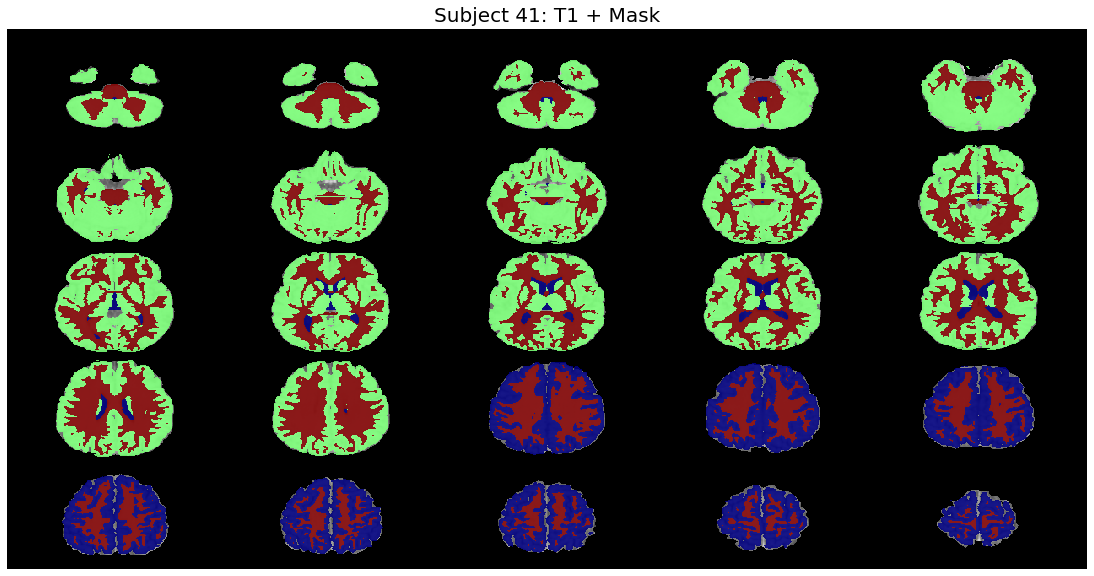

In [0]:
mri_subject = ants.image_read(path_train + '/IBSR_01/IBSR_01.nii.gz')
lesion_mask = ants.image_read(path_train + '/IBSR_01/IBSR_01_seg.nii.gz')
mri_subject.plot(overlay=lesion_mask, nslices=25, axis=2, title='Subject 41: T1 + Mask')

Define paths in options dictionary

In [0]:
options = {}

# training data path
options['training_path'] = path_train

# testing data path 
options['test_path'] = path_test

ROI generation for patches selection. ROIS are generated with the label images (when available) or with a threshold on the original image

In [0]:
#Important for selecting only region of interest. I don't need to train in the whole image

def mask_image(im):
    return (im > 0).astype('float32')

for scan_id in os.listdir(options['training_path']):
    scan = ants.image_read(os.path.join(options['training_path'], 
                                        scan_id, 
                                        scan_id+'_seg.nii.gz')) 
    brainmask = ants.image_clone(scan).apply(mask_image)
    brainmask.to_filename(os.path.join(options['training_path'], 
                                       scan_id, 
                                       scan_id+'_ROI.nii.gz'))
                                       
for scan_id in os.listdir(options['test_path']):
    scan = ants.image_read(os.path.join(options['test_path'], 
                                        scan_id, 
                                        scan_id+'_seg.nii.gz')) 
    brainmask = ants.image_clone(scan).apply(mask_image)
    brainmask.to_filename(os.path.join(options['test_path'], 
                                       scan_id, 
                                       scan_id+'_ROI.nii.gz'))

Define validation cases. We defined images 07 and 16 as validation images 

In [0]:
validation_samples = ['IBSR_07', 'IBSR_16']
input_dictionary = create_training_validation_sets_specific(options, validation_samples)

Check that dictionary of data contains the righ information

In [0]:
input_dictionary['input_val_data']

{'IBSR_07': ['/content/Data/Training_Set/IBSR_07/IBSR_07.nii.gz'],
 'IBSR_16': ['/content/Data/Training_Set/IBSR_16/IBSR_16.nii.gz']}

In [0]:
input_dictionary['input_train_data']

{'IBSR_01': ['/content/Data/Training_Set/IBSR_01/IBSR_01.nii.gz'],
 'IBSR_03': ['/content/Data/Training_Set/IBSR_03/IBSR_03.nii.gz'],
 'IBSR_04': ['/content/Data/Training_Set/IBSR_04/IBSR_04.nii.gz'],
 'IBSR_05': ['/content/Data/Training_Set/IBSR_05/IBSR_05.nii.gz'],
 'IBSR_06': ['/content/Data/Training_Set/IBSR_06/IBSR_06.nii.gz'],
 'IBSR_08': ['/content/Data/Training_Set/IBSR_08/IBSR_08.nii.gz'],
 'IBSR_09': ['/content/Data/Training_Set/IBSR_09/IBSR_09.nii.gz'],
 'IBSR_18': ['/content/Data/Training_Set/IBSR_18/IBSR_18.nii.gz']}

In [0]:

input_dictionary['input_test_data']

{'IBSR_11': ['/content/Data/Validation_Set/IBSR_11/IBSR_11.nii.gz'],
 'IBSR_12': ['/content/Data/Validation_Set/IBSR_12/IBSR_12.nii.gz'],
 'IBSR_13': ['/content/Data/Validation_Set/IBSR_13/IBSR_13.nii.gz'],
 'IBSR_14': ['/content/Data/Validation_Set/IBSR_14/IBSR_14.nii.gz'],
 'IBSR_17': ['/content/Data/Validation_Set/IBSR_17/IBSR_17.nii.gz']}

Display one of the images overlayed with the ROI

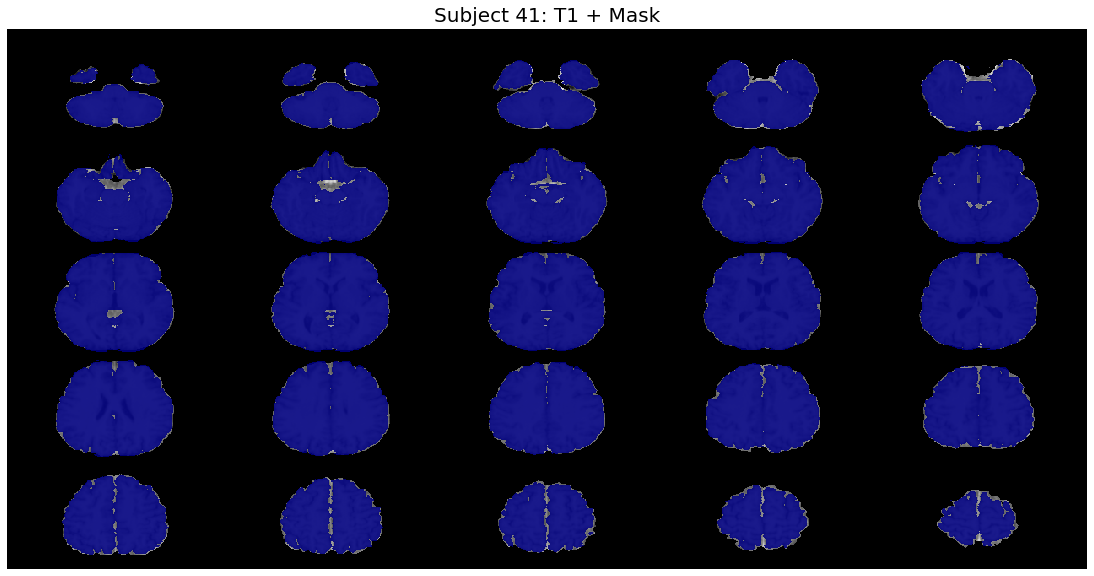

In [0]:
mri_subject.plot(ants.image_read(input_dictionary['input_train_rois']['IBSR_01'][0]), nslices=25, axis=2, title='Subject 41: T1 + Mask')

Generate patches after defining the basic parameters 

In [0]:
from utls import MRI_DataPatchLoader
from torch.utils.data import DataLoader

# additional options for patch size, sampling step, normalization, etc...
options['patch_size'] = (32, 32, 32)
options['sampling_step'] = (16,16,16)
options['normalize'] = True 
options['batch_size'] = 32

print('Training data: ')
training_dataset = MRI_DataPatchLoader(input_data=input_dictionary['input_train_data'],
                                       labels=input_dictionary['input_train_labels'],
                                       rois=input_dictionary['input_train_rois'],
                                       patch_size=options['patch_size'],
                                       sampling_step=options['sampling_step'],
                                       normalize=options['normalize'])

training_dataloader = DataLoader(training_dataset, 
                                 batch_size=options['batch_size'])

print('Validation data: ')
validation_dataset = MRI_DataPatchLoader(input_data=input_dictionary['input_val_data'],
                                        labels=input_dictionary['input_val_labels'],
                                        rois=input_dictionary['input_val_rois'],
                                        patch_size=options['patch_size'],
                                        sampling_step=options['sampling_step'],
                                        normalize=options['normalize'])

validation_dataloader = DataLoader(validation_dataset, 
                                   batch_size=options['batch_size'],
                                   shuffle=True)

print('Test data: ')
test_dataset = MRI_DataPatchLoader(input_data=input_dictionary['input_test_data'],
                                        labels=input_dictionary['input_test_labels'],
                                        rois=input_dictionary['input_test_rois'],
                                        patch_size=options['patch_size'],
                                        sampling_step=options['sampling_step'],
                                        normalize=options['normalize'])

test_dataloader = DataLoader(test_dataset, 
                                   batch_size=options['batch_size'],
                                   shuffle=True)

/usr/local/lib/python3.6/dist-packages/nibabel/testing/__init__.py:21: DeprecationWarning: Importing from numpy.testing.decorators is deprecated since numpy 1.15.0, import from numpy.testing instead.
  from numpy.testing.decorators import skipif


Training data: 
PADDED
> DATA: Loaded scan IBSR_06 roi size: 977824 label_size:  977824
PADDED
> DATA: Loaded scan IBSR_09 roi size: 927415 label_size:  927415
PADDED
> DATA: Loaded scan IBSR_18 roi size: 1590195 label_size:  1590195
PADDED
> DATA: Loaded scan IBSR_03 roi size: 899576 label_size:  899576
PADDED
> DATA: Loaded scan IBSR_05 roi size: 950111 label_size:  950111
PADDED
> DATA: Loaded scan IBSR_04 roi size: 1027700 label_size:  1027700
PADDED
> DATA: Loaded scan IBSR_01 roi size: 1093813 label_size:  1093813
PADDED
> DATA: Loaded scan IBSR_08 roi size: 787260 label_size:  787260
> DATA: Training sample size: 1971
Validation data: 
PADDED
> DATA: Loaded scan IBSR_07 roi size: 799514 label_size:  799514
PADDED
> DATA: Loaded scan IBSR_16 roi size: 1385945 label_size:  1385945
> DATA: Training sample size: 524
Test data: 
PADDED
> DATA: Loaded scan IBSR_13 roi size: 1022741 label_size:  1022741
PADDED
> DATA: Loaded scan IBSR_11 roi size: 889996 label_size:  889996
PADDED
> DA

Remove models folder in case it exists

In [0]:
!rm -r models

rm: cannot remove 'models': No such file or directory


Import jaccard score to be used during training to track improvement of the segmentation in validation

In [0]:
from sklearn.metrics import jaccard_score as jsc

Define class for early stopping
(from https://github.com/Bjarten/early-stopping-pytorch)

In [0]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

Define patience for early stopping and number of classes

In [0]:
options['patience'] = 30
n_classes = 4

Define Dice Loss

In [0]:
#Modified from https://github.com/rogertrullo/pytorch/blob/rogertrullo-dice_loss/torch/nn/functional.py#L708
def dice_loss(input,target):
    """
    input is a torch variable of size BatchxnclassesxHxW representing log probabilities for each class
    target is a 1-hot representation of the groundtruth, shoud have same size as the input
    """
    assert input.size() == target.size(), "Input sizes must be equal."
    assert input.dim() == 5, "Input must be a 5D Tensor."
    # uniques=np.unique(target.numpy())
    # assert set(list(uniques))<=set([0,1]), "target must only contain zeros and ones"

    probs=F.softmax(input, dim=1)
    num=probs*target#b,c,h,w--p*g
    num=torch.sum(num,dim=4)#b,c,h
    num=torch.sum(num,dim=3)
    num=torch.sum(num,dim=2)
    

    den1=probs*probs#--p^2
    den1=torch.sum(den1,dim=4)#b,c,h
    den1=torch.sum(den1,dim=3)
    den1=torch.sum(den1,dim=2)
    

    den2=target*target#--g^2
    den2=torch.sum(den2,dim=4)#b,c,h
    den2=torch.sum(den2,dim=3)#b,c
    den2=torch.sum(den2,dim=2)#b,c
    

    dice=2*(num/(den1+den2))
    dice_eso=dice[:,0:]

    dice_total=-1*torch.sum(dice_eso)/dice_eso.size(0)#divide by batch_sz

    return dice_total

##Training loop

In this section the architecture to be used has to be specified. By default is the basic UNet with the modified number of feature maps. The loss is set to dice loss. It can be modified by uncommenting the cross entropy loss and commenting the dice loss out

In [0]:
from torch.optim import Adadelta, Adam
from torchvision.models.segmentation import deeplabv3_resnet50

# mkdir for stored models
!mkdir models


# Define the Unet model 
# 2 input channels (FLAIR and T1)
# 2 output classes (healthy and wmh) (we ignore other pathologies)
#lesion_model = VNetBN()
#lesion_model = Unet(input_size=1, output_size=4)
lesion_model = Unet2(input_size=1, output_size=4)
#lesion_model = UnetHulk(input_size=1, output_size=4)
#lesion_model = deeplabv3_resnet50(pretrained=False, progress=True,num_classes=3)

# some training options
options['gpu_use'] = True
options['num_epochs'] = 200

# define the torch.device
device = torch.device('cuda') if options['gpu_use'] else torch.device('cpu')

# define the optimizer
optimizer = Adadelta(lesion_model.parameters())
#optimizer = Adam(lesion_model.parameters())

# send the model to the device
lesion_model = lesion_model.to(device)

early_stopping = EarlyStopping(patience=options['patience'], verbose=True)

train_losses = []
val_losses = []
train_jaccs = []
val_jaccs = []

# training loop
training = True
epoch = 1
try:
    while training:
    
        # epoch specific metrics
        train_loss = 0
        val_loss = 0

        train_jacc = 0
        val_jacc = 0
        jaccs_train = []
        jaccs_val = []
        
        # -----------------------------
        # training samples
        # -----------------------------
        
        # set the model into train mode
        lesion_model.train()
        for b_t, batch in enumerate(training_dataloader):
                # process batches: each batch is composed by training (x) and labels (y)
                # x = [32, 2, 32, 32, 32]
                # y = [32, 1, 32, 32, 32]
    
                x = batch[0].to(device)
                y = batch[1].to(device)

                # clear gradients
                optimizer.zero_grad()
                
                # infer the current batch 
                pred = lesion_model(x)

                #Convert GT to one-hot for use in dice loss
                y_one_hot = torch.FloatTensor(x.size(0), 4, x.size(2), x.size(3), x.size(4))
                y_one_hot = y_one_hot.to(device)
                y_one_hot.scatter_(1,y.type(torch.LongTensor).to(device),1)

                #loss
                loss = dice_loss(torch.log(torch.clamp(pred, 1E-7, 1.0)), y_one_hot)
                #loss = F.cross_entropy(torch.log(torch.clamp(pred, 1E-7, 1.0)),
                #                      y.squeeze(dim=1).long())

                train_loss += loss.item()
                
                # backward loss and next step
                loss.backward()
                optimizer.step()

                # compute the accuracy
                pred = pred.max(1, keepdim=True)[1]
                #batch_jacc = iou(pred, y.view_as(pred))
                lbl = y.cpu().numpy().reshape(-1)
                target = pred.cpu().numpy().reshape(-1)
                batch_jacc = jsc(target,lbl, average = 'weighted')
                jaccs_train.append(batch_jacc)
                
        # -----------------------------
        # validation samples
        # -----------------------------
    
        # set the model into train mode
        lesion_model.eval()
        for b_v, batch in enumerate(validation_dataloader):
                x = batch[0].to(device)
                y = batch[1].to(device)
                
                # infer the current batch 
                with torch.no_grad():
                    pred = lesion_model(x)

                    #Convert GT to one-hot for use in dice loss
                    y_one_hot = torch.FloatTensor(x.size(0), 4, x.size(2), x.size(3), x.size(4))
                    y_one_hot = y_one_hot.to(device)
                    y_one_hot.scatter_(1,y.type(torch.LongTensor).to(device),1)

                    # compute the loss. 
                    loss = dice_loss(torch.log(torch.clamp(pred, 1E-7, 1.0)), y_one_hot)
                    
                    #loss = F.cross_entropy(torch.log(torch.clamp(pred, 1E-7, 1.0)),
                    #                      y.squeeze(dim=1).long())
                    val_loss += loss.item()
                
                    # compute the accuracy 
                    pred = pred.max(1, keepdim=True)[1]
                    
                    lbl = y.cpu().numpy().reshape(-1)
                    target = pred.cpu().numpy().reshape(-1)
                    batch_jacc = jsc(target,lbl, average = 'weighted')
                    jaccs_val.append(batch_jacc)
                    
                
        
        # compute mean metrics
        train_loss /= (b_t + 1)
        val_loss /= (b_v + 1)
        train_jacc = np.mean(np.array(jaccs_train))
        val_jacc = np.mean(np.array(jaccs_val))

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_jaccs.append(train_jacc)
        val_jaccs.append(val_jacc)


        print('Epoch {:d} train_loss {:.4f} train_jacc {:.4f} val_loss {:.4f} val_jacc {:.4f}'.format(
            epoch, 
            train_loss, 
            train_jacc,
            val_loss,
            val_jacc))
        # update epochs
        epoch += 1
        
        early_stopping(val_loss, lesion_model)
        if early_stopping.early_stop:
          print("Early stopping")
          break

        if epoch > options['num_epochs']:
            training = False

    lesion_model.load_state_dict(torch.load('checkpoint.pt'))

except KeyboardInterrupt:
    pass

Epoch 1 train_loss -2.1772 train_jacc 0.6457 val_loss -2.3472 val_jacc 0.7074
Validation loss decreased (inf --> -2.347192).  Saving model ...
Epoch 2 train_loss -2.3674 train_jacc 0.7880 val_loss -2.6153 val_jacc 0.8132
Validation loss decreased (-2.347192 --> -2.615299).  Saving model ...
Epoch 3 train_loss -2.4336 train_jacc 0.8038 val_loss -2.5824 val_jacc 0.8083
EarlyStopping counter: 1 out of 30
Epoch 4 train_loss -2.5331 train_jacc 0.8013 val_loss -2.3380 val_jacc 0.7776
EarlyStopping counter: 2 out of 30
Epoch 5 train_loss -2.4398 train_jacc 0.7680 val_loss -2.4310 val_jacc 0.7656
EarlyStopping counter: 3 out of 30
Epoch 6 train_loss -2.5569 train_jacc 0.7965 val_loss -2.4613 val_jacc 0.7943
EarlyStopping counter: 4 out of 30
Epoch 7 train_loss -2.6022 train_jacc 0.8059 val_loss -2.7890 val_jacc 0.8348
Validation loss decreased (-2.615299 --> -2.788966).  Saving model ...
Epoch 8 train_loss -2.6513 train_jacc 0.7932 val_loss -2.4255 val_jacc 0.7803
EarlyStopping counter: 1 out 

Load model (just in case the colab environment dies)

In [0]:
lesion_model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

##Plot learning curve

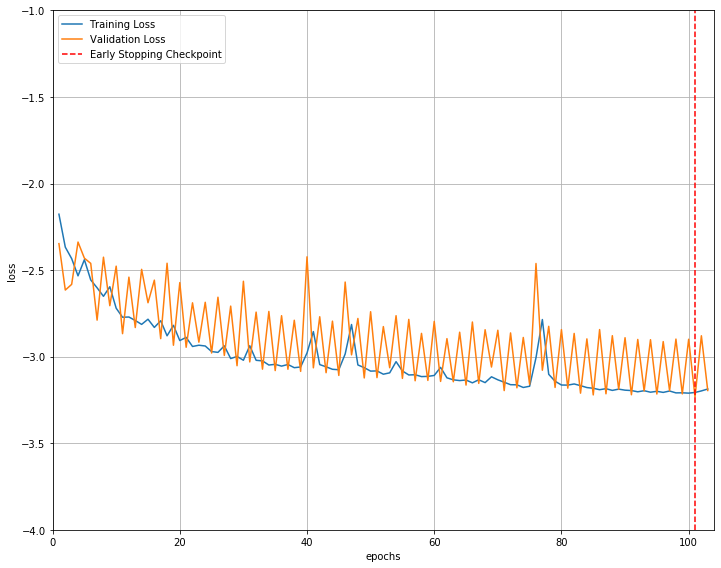

In [0]:
import matplotlib.pyplot as plt
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_losses)+1),train_losses, label='Training Loss')
plt.plot(range(1,len(val_losses)+1),val_losses,label='Validation Loss')

# find position of lowest validation loss
minposs = val_losses.index(min(val_losses))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_losses)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.ylim((-4, -1))
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

Define function for reconstructing image from patches

In [0]:
def build_image(infer_patches):
  lesion_out = np.zeros_like(infer_patches).astype('float32')
  sh = infer_patches.shape
  lesion_out = np.zeros((sh[0], 4, sh[2], sh[3], sh[4]))
  batch_size = options['batch_size']
  b =0
  # model
  lesion_model.eval()
  with torch.no_grad():
      for b in range(0, len(lesion_out), batch_size):
          x = torch.tensor(infer_patches[b:b+batch_size]).to(device)
          pred = lesion_model(x)
          # save the result back from GPU to CPU --> numpy
          lesion_out[b:b+batch_size] = pred.cpu().numpy()
  return lesion_out

##Evaluate one of the validation images

In [0]:
from utls import get_inference_patches, reconstruct_image

scan_path = os.path.join(options['test_path'], "IBSR_11")
scan = ants.image_read(os.path.join(scan_path, "IBSR_11.nii.gz"))

infer_patches, coordenates = get_inference_patches(scan_path=scan_path,
                                          input_data=["IBSR_11.nii.gz"],
                                          roi="IBSR_11_ROI.nii.gz",
                                          patch_shape=options['patch_size'],
                                          step=options['sampling_step'],
                                          normalize=options['normalize'])

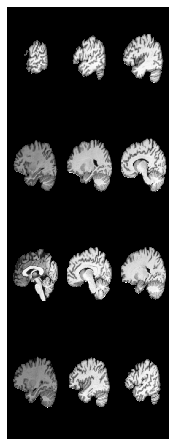

In [0]:
scan.plot()

GEnerate outputs from the model

In [0]:
lesion_out = build_image(infer_patches)
scan_numpy = scan.numpy()
all_probs = np.zeros((scan_numpy.shape[0], scan_numpy.shape[1], scan_numpy.shape[2], 4))
all_probs.shape
for i in range(4):
  all_probs[:,:,:,i] = reconstruct_image(lesion_out[:,i], 
                                  coordenates, 
                                  scan.shape)

Build labels images from probabilities

In [0]:
labels = np.argmax(all_probs, axis=3)
segm_img = ants.from_numpy(labels.astype(np.uint8))
segm_img = ants.copy_image_info(scan, segm_img)

In [0]:
np.unique(labels)

array([0, 1, 2, 3])

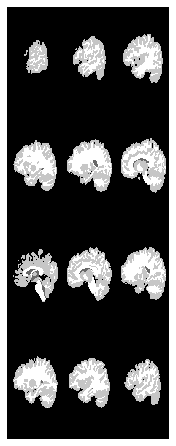

In [0]:
segm_img.plot()

In [0]:
ants.image_write(segm_img, "segmented_dummy.nii.gz")

##Get measures

Get ground truth

In [0]:
gt = ants.image_read(os.path.join(scan_path, "IBSR_11_seg.nii.gz")).numpy().flatten()

In [0]:
segmentation = segm_img.numpy().flatten()

Dices

In [0]:
def compute_dices(gt, pred):
  ''' Function to calculate DSC for two vectors 
  '''
  dices = np.zeros((np.max(gt),))
  for i in range(np.max(gt)):
    gt_bool = np.zeros_like(gt, dtype = np.bool)
    segm_bool = np.zeros_like(pred, dtype = np.bool)
    gt_bool[gt==i+1] = True
    segm_bool[pred==i+1] = True
    if(not np.sum(gt_bool)+ np.sum(segm_bool)):
      dices[i] = 1.0
      continue
    dices[i] = (2. * np.sum(gt_bool * segm_bool)) / (np.sum(gt_bool) + np.sum(segm_bool))
  return dices

Volumetric difference

In [0]:
def _avd_tissue(volume, gt):
  difference = np.abs(np.sum(volume) - np.sum(gt)).astype(np.float)
  total = np.sum(gt).astype(np.float)
  avd = difference / total
  return avd

def absolute_volumetric_difference(tissues, volume: np.array, gt: np.array):
  volume = volume.astype(np.uint8)
  gt = gt.astype(np.uint8)
  avd_per_tissue = np.zeros([tissues, ])
  for tissue_id in range(1, tissues + 1):
        volume_counter = 1 * (volume == tissue_id)
        mask_counter = 1 * (gt == tissue_id)
        avd_tissue = _avd_tissue(volume_counter, mask_counter)
        avd_per_tissue[tissue_id - 1] = avd_tissue
    
  return avd_per_tissue

Hausdorff distance

In [0]:
import SimpleITK as sitk
#Hausdorf distance
def compute_hausdorf(gt_itk, pred_itk):
  gt = sitk.GetArrayFromImage(gt_itk)
  pred = sitk.GetArrayFromImage(pred_itk)
  h_distances = np.zeros((np.max(gt),))
  for i in range(3):
    hd = sitk.HausdorffDistanceImageFilter()
    gt_new = np.zeros_like(gt, dtype = np.uint8)
    segm_new = np.zeros_like(pred, dtype = np.uint8)
    gt_new[gt==i+1] = 1
    segm_new[pred==i+1] = 1
    gt_itk = sitk.GetImageFromArray(gt_new)
    gt_itk.CopyInformation(gt_itk)
    segm_itk = sitk.GetImageFromArray(segm_new)
    segm_itk.CopyInformation(gt_itk)
    hd.Execute(gt_itk, segm_itk)
    h_distances[i] = hd.GetHausdorffDistance()
  return h_distances

In [0]:
dices = compute_dices(gt.astype(np.uint8), segmentation.astype(np.uint8))

In [0]:
dices

array([0.88902359, 0.93367429, 0.95288008])

In [0]:
vds = absolute_volumetric_difference(3, segmentation.astype(np.uint8),gt.astype(np.uint8))

In [0]:
vds

In [0]:
hausdorf = compute_hausdorf(ants.image_read(os.path.join(scan_path, "IBSR_11_seg.nii.gz")).numpy().astype(np.uint8),segm_img.numpy().astype(np.uint8))

In [0]:
hausdorf

array([28.72281323,  8.1240384 ,  7.28010989])

## Evaluate all test images

In [0]:
from utls import get_inference_patches, reconstruct_image

In [0]:
test_images = input_dictionary['input_test_data'].keys()

List images of test (validation) set

In [0]:
list(test_images)

['IBSR_13', 'IBSR_11', 'IBSR_17', 'IBSR_12', 'IBSR_14']

Iterate through every image

In [0]:
for img in test_images:
  scan_path = os.path.join(options['test_path'], img)

  scan = ants.image_read(os.path.join(scan_path, img + ".nii.gz"))

  infer_patches, coordenates = get_inference_patches(scan_path=scan_path,
                                            input_data=[img + ".nii.gz"],
                                            roi=img +"_ROI.nii.gz",   
                                            patch_shape=options['patch_size'],
                                            step=options['sampling_step'],
                                            normalize=options['normalize'])
  image_from_patches = build_image(infer_patches)

  scan_numpy = scan.numpy()
  all_probs = np.zeros((scan_numpy.shape[0], scan_numpy.shape[1], scan_numpy.shape[2], 4))

  for i in range(4):
    all_probs[:,:,:,i] = reconstruct_image(image_from_patches[:,i], 
                                    coordenates, 
                                    scan.shape)

  labels = np.argmax(all_probs, axis=3)
  segm_img = ants.from_numpy(labels.astype(np.uint8))
  segm_img = ants.copy_image_info(scan, segm_img)

  ants.image_write(segm_img, os.path.join(img + "_segmented.nii.gz"))

  gt = ants.image_read(os.path.join(scan_path, img + "_seg.nii.gz")).numpy().flatten()
  segmentation = segm_img.numpy().flatten()
  dices = compute_dices(gt.astype(np.uint8), segmentation.astype(np.uint8))
  print(img + " dices:")
  print(dices)

/content/utls.py:468: RuntimeWarning: invalid value encountered in true_divide
  out_image /= freq_count


IBSR_13 dices:
[0.86907449 0.93978083 0.9257401 ]
IBSR_11 dices:
[0.88329298 0.94525734 0.95939401]
IBSR_17 dices:
[0.91513229 0.93387232 0.90494435]
IBSR_12 dices:
[0.89009354 0.93025209 0.93884953]
IBSR_14 dices:
[0.92680802 0.93687398 0.92812736]


Segmented images should be stored in /content/gdrive/My Drive, which is the main path in Colab, so the images should appear on the left subwindow in the Files tab.